# Figure 5: Baseline comparison on Synthetic data
This notebook compares the accuracy and the wall clock time for various GP ensemble methods

In [6]:
import numpy as np
import tensorflow as tf
import gpflow
import guepard
import matplotlib.pyplot as plt
import scipy
import time

from guepard.utilities import get_gpr_submodels
from guepard.baselines import EnsembleMethods, WeightingMethods

rng = np.random.RandomState(123)
tf.random.set_seed(42)

RUN_EXPERIMENT = False   # if False, loads an npz file with experiment results and does the plotting 

# Set the parameters of the experiment
d = 5                   # input space dimension
n = 2**4 * 4**d         # number of observation points
p = 4**d                # number of submodels

num_rep = 2             # how many times the experiment is repeated (num_rep = 5 in the paper). Test functions are GP samples

print(f"n = {n}, d = {d}, p = {p}")

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"));


n = 16384, d = 5, p = 1024


In [2]:
kernel = gpflow.kernels.Matern52(lengthscales=[1.]*d)
noise_var = 1e-2

lik = gpflow.likelihoods.Gaussian()
lik.variance.assign(noise_var)

mean_function = gpflow.mean_functions.Zero()

We generate samples from the prior distribution as test function.


time for generating data:  48.345004081726074


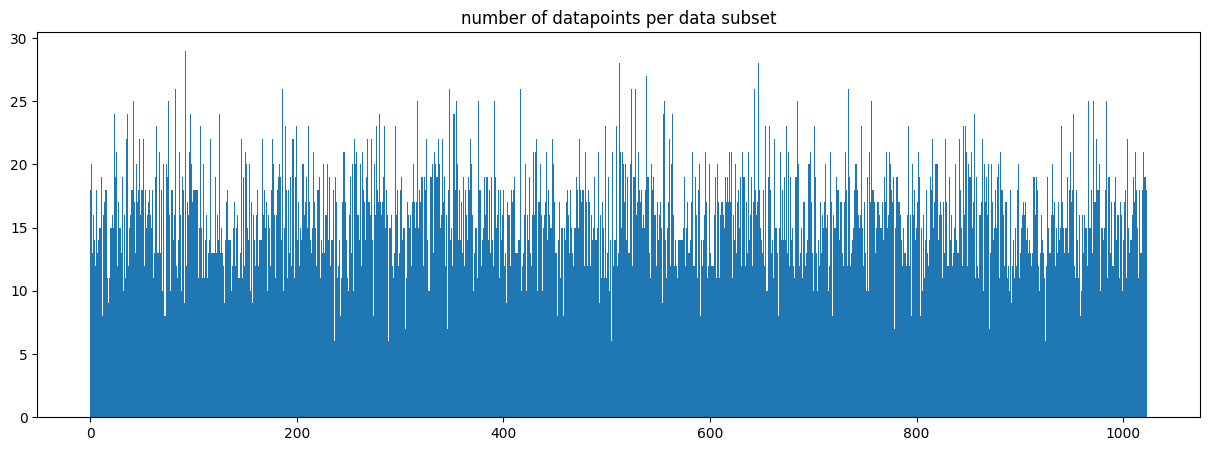

In [4]:
def make_data(n_train, n_test, d):
    # generates train and test datasets
    n = n_train + n_test
    X = np.random.uniform(size=(n, d))
    Y = np.empty((n, 1))

    dummy_data = np.array([[100.]]*d).T, np.array([[0.]])
    F = gpflow.models.GPR(dummy_data, kernel).predict_f_samples(X, 1).numpy()[0]
    Y = F + np.random.normal(0, np.sqrt(noise_var), size=F.shape)
    return X[:n_train, :], Y[:n_train, :], X[n_train:, :], Y[n_train:, :]

def get_subgroup(X):
    d = X.shape[1]
    z = np.linspace(1/8, 7/8, 4)
    Z = np.meshgrid(*([z]*d))
    Z = np.array([z.flatten() for z in Z]).T

    D2 = np.sum((X[:, None, :] - Z[None, :, :])**2, axis=-1)

    ind = np.argmin(D2, axis=1)
    return(ind)

start_time = time.time()
X, Y, Xtest, Ytest = make_data(n, 100, d)
ind = get_subgroup(X)
wct = time.time() - start_time
print("time for generating data: ", wct)

plt.figure(figsize=(15, 5))
plt.hist(ind, bins=p)
plt.title("histogram of the number of datapoints per data subset");



In [8]:
if RUN_EXPERIMENT:

    list_method = [EnsembleMethods.BARY, EnsembleMethods.GPOE, EnsembleMethods.RBCM]
    list_weight = [WeightingMethods.VAR, WeightingMethods.VAR, WeightingMethods.ENT]

    method_name = [met.value for met in EnsembleMethods] + [m.value + w.value for m, w in zip(list_method, list_weight)] + ["Equiv. Obs.", "NestedGP"]
    num_models = len(method_name)

    NLPD = np.zeros((num_rep, num_models))
    TIME = np.zeros((num_rep, num_models)) 
    for i in range(num_rep):
        # Generate data
        print(f'------------ iteration {i} ------------')
        start_time = time.time()
        X, Y, Xtest, Ytest = make_data(n, 100, d)
        ind = get_subgroup(X)
        datasets = [(X[ind==i, :], Y[ind==i, :]) for i in range(p)]
        wct = time.time() - start_time
        print("time for generating data: ", wct)

        # get submodels
        submodels = get_gpr_submodels(datasets, kernel, mean_function=mean_function, noise_variance=noise_var)

        # NLPD and timing for PoE, GPoe, BCM, rBCM, BAR
        for j, method in enumerate(EnsembleMethods):
            start_time = time.time()
            m = guepard.Ensemble(submodels, method, WeightingMethods.NONE)
            NLPD[i, j] = -np.mean(m.predict_log_density((Xtest, Ytest)))
            TIME[i, j] = time.time() - start_time

        for method, weight in zip(list_method, list_weight):
            j += 1
            start_time = time.time()
            m = guepard.Ensemble(submodels, method, weight)
            NLPD[i, j] = -np.mean(m.predict_log_density((Xtest, Ytest)))
            TIME[i, j] = time.time() - start_time

        start_time = time.time()
        m = guepard.EquivalentObsEnsemble(submodels)
        NLPD[i, j+1] = -np.mean(m.predict_log_density((Xtest, Ytest)))
        TIME[i, j+1] = time.time() - start_time 

        start_time = time.time()
        m = guepard.NestedGP(submodels)
        NLPD[i, j+2] = -np.mean(m.predict_log_density((Xtest, Ytest)))
        TIME[i, j+2] = time.time() - start_time 

        print('time: ', np.round(TIME[i, :], 2))
        print('nlpd: ', np.round(NLPD[i, :], 2))

    np.savez(f"data/synthetic-d_{d}-n_{n}-p_{p}-nrep_{num_rep}.npz", TIME=TIME, NLPD=NLPD, method_name=method_name)


if not RUN_EXPERIMENT:
    npzfile = np.load(f"data/synthetic-d_{d}-n_{n}-p_{p}-nrep_{num_rep}.npz")
    TIME = npzfile["TIME"]
    NLPD = npzfile["NLPD"]
    method_name = npzfile["method_name"]

    num_models = len(method_name)   


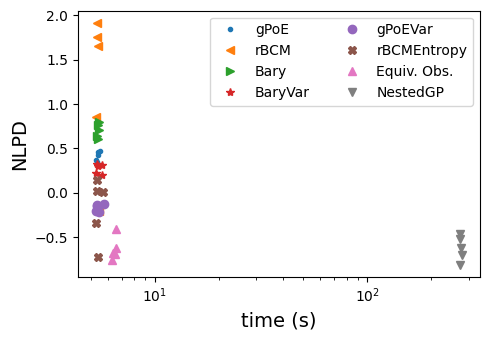

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
plt.gca().set_prop_cycle(marker=['.', '<', '>', '*', 'o', 'X', '^', 'v']) # gca()=current axis

j = -1
for i in range(num_models):
    if i not in [0, 2]:
        j += 1
        plt.plot(TIME[:, i], NLPD[:, i], linestyle="", color=f"C{j}", label=method_name[i])


plt.legend(ncol=2)
plt.xlabel('time (s)', fontsize=14)
plt.ylabel('NLPD', fontsize=14)
plt.semilogx()
plt.tight_layout()
plt.savefig(f"figures/synthetic-d_{d}-n_{n}-p_{p}.pdf")